In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import curve_fit
import emcee
import corner

In [3]:
figsize(8, 6)

In [4]:
n = 25
x = np.arange(n, dtype=float)
m = -2.4
b = 1.7
errs = 3. * np.random.random(n) + 0.1
y = m * x + b
y += errs * np.random.randn(n)

In [5]:
def line(x, m, b):
    return m * x + b

In [6]:
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

In [7]:
errs.std()

0.65587312985674828

In [8]:
errs.mean()

1.4365959563402877

In [9]:
(y - line(x, m, b)).std()

1.1034169552996649

In [10]:
popt = curve_fit(line, x, y, sigma=errs)

In [11]:
popt1 = curve_fit(quadratic, x, y, sigma=errs)

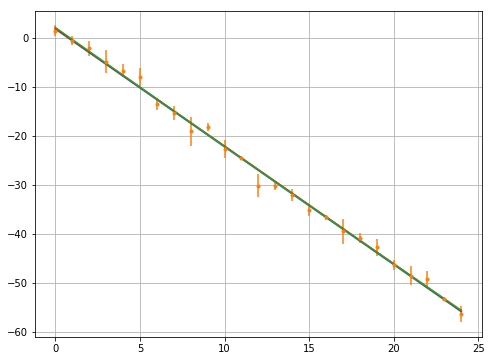

In [12]:
plot(x, m*x+b)
errorbar(x, y, errs, fmt='.')
plot(x, line(x, *popt[0]), 'r')
plot(x, quadratic(x, *popt1[0]))
grid()

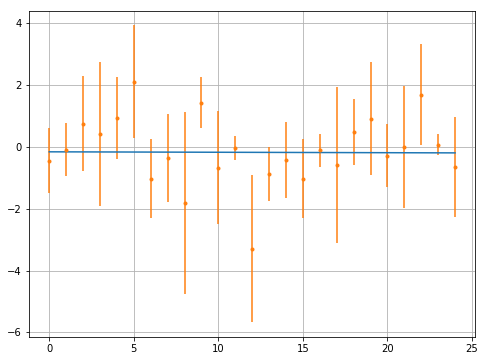

In [13]:
plot(x, line(x, m, b) - line(x, *popt[0]))
errorbar(x, y - line(x, *popt[0]), errs, fmt='.')
grid()

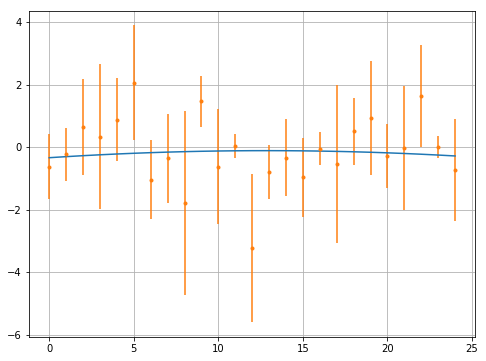

In [14]:
plot(x, line(x, m, b) - quadratic(x, *popt1[0]))
errorbar(x, y - quadratic(x, *popt1[0]), errs, fmt='.')
grid()

In [15]:
rchisq1 = np.sum( (y - line(x, *popt[0]))**2 / errs**2) / (n - 2.)

In [16]:
rchisq2 = np.sum( (y - quadratic(x, *popt1[0]))**2 / errs**2) / (n - 3.)

In [17]:
rchisq1

0.52856058250934479

In [18]:
rchisq2

0.54571634429591209

In [19]:
def lnprior(theta):
    return 0.

In [20]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [21]:
def lnlike(theta, x, y, yerr):
    model = line(x, *theta)
    return -0.5 * (np.sum((y-model)**2. * yerr**-2.))

In [22]:
ndim, nwalkers = 2, 32
pos = [popt[0] * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [23]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, errs))

In [24]:
sampler1.run_mcmc(pos, 1024);

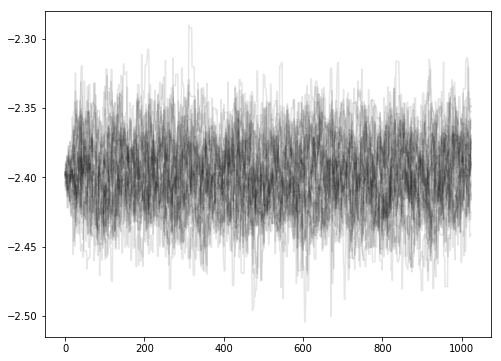

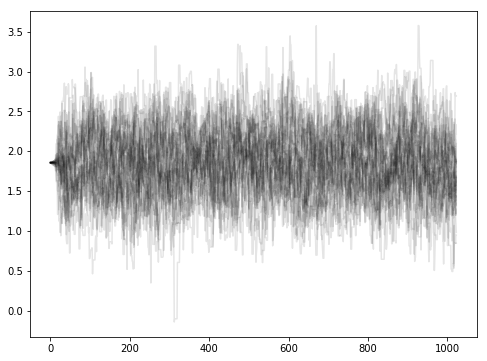

In [25]:
for k in range(ndim):
    figure()
    plot(sampler1.chain[:,:,k].T, color='k', alpha=0.1);

In [26]:
samples1 = sampler1.chain[:, 200:, :].reshape((-1, ndim))

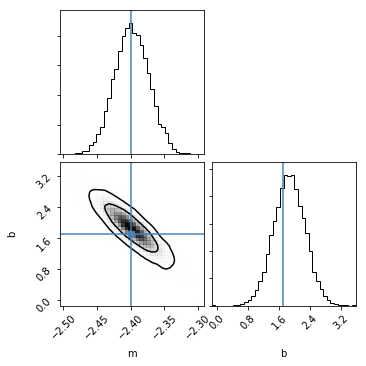

In [27]:
fig = corner.corner(samples1, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["m", "b"], truths=[m, b])

In [28]:
def lnprob2(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y, yerr)

In [29]:
def lnlike2(theta, x, y, yerr):
    model = quadratic(x, *theta)
    return -0.5 * (np.sum((y-model)**2. * yerr**-2.))

In [30]:
ndim, nwalkers = 3, 32
pos = [popt1[0] * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [31]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y, errs))

In [32]:
sampler2.run_mcmc(pos, 1024);

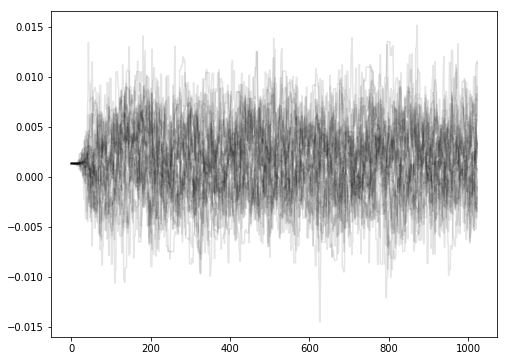

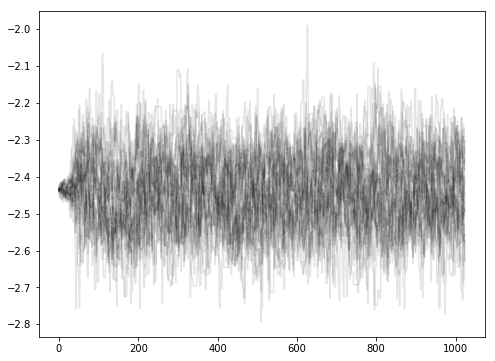

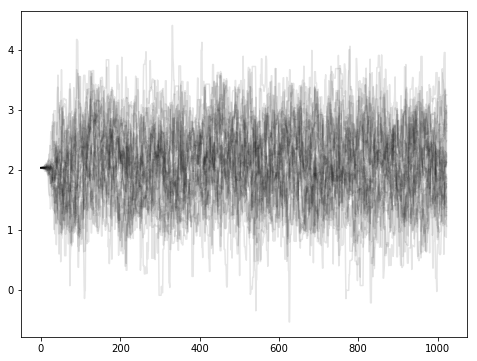

In [33]:
for k in range(ndim):
    figure()
    plot(sampler2.chain[:,:,k].T, color='k', alpha=0.1);

In [34]:
samples2 = sampler2.chain[:, 200:, :].reshape((-1, ndim))

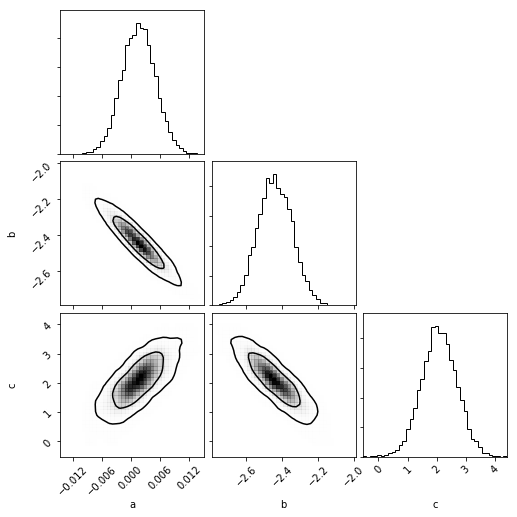

In [35]:
fig = corner.corner(samples2, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["a", "b", "c"])

In [36]:
samples1.min(0)

array([-2.50424468, -0.13798878])

In [37]:
samples1.max(0)

array([-2.29038348,  3.57817388])

In [38]:
from scipy import integrate

In [39]:
xlim, ylim = zip(samples1.min(0), samples1.max(0))

In [46]:
xarr = x.copy()
data = y.copy()
dataerrs = errs.copy()

In [102]:
def integrand(b, m, xarr=xarr, data=data, dataerrs=dataerrs):
    return np.exp(lnlike([m, b], xarr, data, dataerrs))

In [103]:
integrate.dblquad(integrand, xlim[0], xlim[1], lambda x: ylim[0], lambda x: ylim[1])

(6.482131911652664e-05, 5.789072655552755e-09)

In [107]:
xlim, ylim, zlim = zip(samples2.min(0), samples2.max(0))

In [108]:
def integrand2(c, b, a, xarr=xarr, data=data, dataerrs=dataerrs):
    return np.exp(lnlike2([a, b, c], xarr, data, dataerrs))

In [111]:
integrate.tplquad(integrand2, xlim[0], xlim[1], lambda x: ylim[0], lambda x: ylim[1], \
                  lambda x, y: zlim[0], lambda x, y: zlim[1])

(6.167380460138202e-07, 1.4656989834730876e-08)

In [112]:
6.167380460138202e-07 / 6.482131911652664e-05

0.00951443220254644

In [113]:
6.167380460138202e-07 / (6.482131911652664e-05 + 6.167380460138202e-07)

0.009424760953429824

In [114]:
6.482131911652664e-05 / (6.482131911652664e-05 + 6.167380460138202e-07)

0.9905752390465701

In [99]:
ns = 1000
xs = np.linspace(xlim[0], xlim[1], ns)
dx = (xlim[1] - xlim[0]) / len(xs)
ys = np.linspace(ylim[0], ylim[1], ns)
dy = (ylim[1] - ylim[0]) / len(xs)

In [100]:
tot = 0
for k in range(len(xs)):
    for j in range(len(xs)):
        tot += integrand(xs[k], ys[j]) * dx * dy

In [115]:
print tot

6.46917807912e-05


In [98]:
print tot

6.45623715767e-05


In [95]:
print tot

6.41749185839e-05


In [92]:
print tot

6.35317456995e-05


In [71]:
mt = np.random.random(1) * (xlim[1] - xlim[0]) + xlim[0]
bt = np.random.random(1) * (ylim[1] - ylim[0]) + ylim[0]
integrand(mt, bt)

2.5932050962602231e-30

In [116]:
prob1 = 0
for k in range(len(samples1)):
    prob1 += np.exp(lnlike(samples1[k], x, y, errs))

In [117]:
prob2 = 0
for k in range(len(samples2)):
    prob2 += np.exp(lnlike2(samples2[k], x, y, errs))

In [118]:
prob1

29.852226805805177

In [119]:
prob2

22.8801824503307

In [120]:
prob2 / prob1

0.76644809779755974

In [ ]:
def gauss()